### Import Libraries

In [3]:
#Mounting the notebook to the drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
import pandas as pd
import matplotlib.cm as cm
from matplotlib import rcParams
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
from collections import Counter 
from sklearn import preprocessing
import re,os
from wordcloud import WordCloud
import pandas
import string
from nltk.corpus import stopwords
import gensim
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [5]:
!pip install spacy==2.2.3
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall
!pip install catboost==1.0.0
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install tensorflow_hub
!pip install tensorflow_text
!pip install tf-models-official

     |████████████████████████████████| 10.4 MB 5.0 MB/s 
     |████████████████████████████████| 2.2 MB 26.0 MB/s 
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 12.0 MB 5.6 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 115 kB 5.4 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-ue53qh6s
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from catboost import CatBoostClassifier,Pool
from catboost.utils import get_confusion_matrix
import preprocess_kgptalkie as ps

Installing some dependencies

### Load the dataset

In [ ]:
true_news=pd.read_csv('True.csv')

In [ ]:
fake_news=pd.read_csv('Fake.csv')

In [ ]:
true_news['label']='fake'
fake_news['label']='true'

data = pd.concat([true_news, fake_news], axis=0)

In [ ]:
data.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",fake
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",fake
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",fake
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",fake
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",fake


In [ ]:
# Selection of the interested columns for feature extraction 
data=data[['text','label']]

In [ ]:
data['text']=data['text'].str.lower()
data['text'].head()

0    washington (reuters) - the head of a conservat...
1    washington (reuters) - transgender people will...
2    washington (reuters) - the special counsel inv...
3    washington (reuters) - trump campaign adviser ...
4    seattle/washington (reuters) - president donal...
Name: text, dtype: object

In [ ]:
data.columns

Index(['text', 'label'], dtype='object')

In [ ]:
data['label'].unique()

array(['fake', 'true'], dtype=object)

In [ ]:
data.dtypes

text     object
label    object
dtype: object

In [ ]:
data[data.isnull().any(axis=1)]

,text,label


In [ ]:
#Number of null
import numpy as np
np.sum(data.isnull().any(axis=1))

0

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44898 non-null  object
 1   label   44898 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


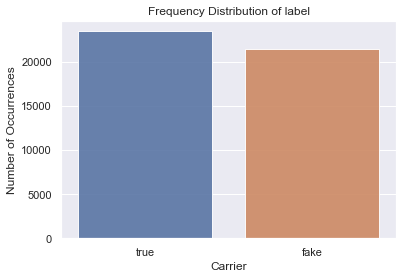

In [ ]:
%matplotlib inline
carrier_count = data["label"].value_counts()
sns.set(style="darkgrid")
sns.barplot(carrier_count.index, carrier_count.values, alpha=0.9)
plt.title('Frequency Distribution of label')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Carrier', fontsize=12)
plt.show()

In [ ]:
data["label"].value_counts()

true    23481
fake    21417
Name: label, dtype: int64

In [ ]:
data.loc[data["text"].str.contains('america'), 'text'] = 'american'
data.loc[data["text"].str.contains('americans'), 'text'] = 'american'
data.loc[data["text"].str.contains('youore'), 'text'] = 'you are'
data.loc[data["text"].str.contains('youre'), 'text'] = 'you are'
data.loc[data["text"].str.contains('years'), 'text'] = 'year'
data.loc[data["text"].str.contains('break'), 'text'] = 'breakingnews'
data.loc[data["text"].str.contains('breaking'), 'text'] = 'breakingnews'
data.loc[data["text"].str.contains('caused'), 'text'] = 'cause'
data.loc[data["text"].str.contains('causes'), 'text'] = 'cause'
data.loc[data["text"].str.contains('county'), 'text'] = 'country'
for letter in '1234567890.(/':
    data["text"] = data["text"].str.replace(letter,'')

In [ ]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations + english_punctuations

def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [ ]:
def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [ ]:
def processPost(text): 

    text = re.sub('@[^\s]+', ' ', text)
    

    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text)

    text = re.sub(r'#([^\s]+)', r'\1', text)

    text= remove_punctuations(text)
    text=remove_repeating_char(text)
    
    return text

In [ ]:
data["text"] = data["text"].apply(lambda x: processPost(x))

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
data["text"] = data["text"].apply(tokenizer.tokenize)

In [ ]:
data["text"].head()

0                                               [year]
1                                           [american]
2    [washington, reuters, the, special, counsel, i...
3                                           [american]
4                                           [american]
Name: text, dtype: object

In [ ]:
stopwords_list = stopwords.words('english')

In [ ]:
data["text"]=data["text"].apply(lambda x: [item for item in x if item not in stopwords_list])

In [ ]:
data["text"].head()

0                                               [year]
1                                           [american]
2    [washington, reuters, special, counsel, invest...
3                                           [american]
4                                           [american]
Name: text, dtype: object

In [ ]:
all_words = [word for tokens in data["text"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in data["text"]]

VOCAB = sorted(list(set(all_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

3138438 words total, with a vocabulary size of 90312
Max sentence length is 1511


<BarContainer object of 25 artists>

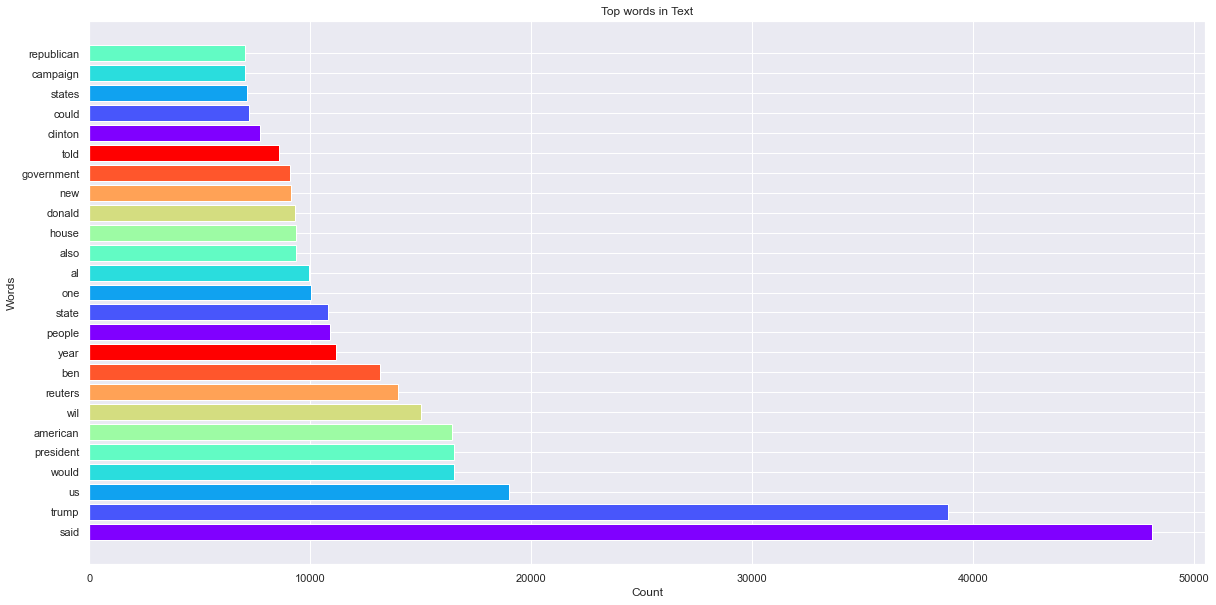

In [ ]:
#Most common 25 words
counter = Counter(all_words)
counter.most_common(25)
counted_words = Counter(all_words)

words = []
counts = []
for letter, count in counted_words.most_common(25):
    words.append(letter)
    counts.append(count)

colors = cm.rainbow(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 20, 10

plt.title('Top words in Text')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)

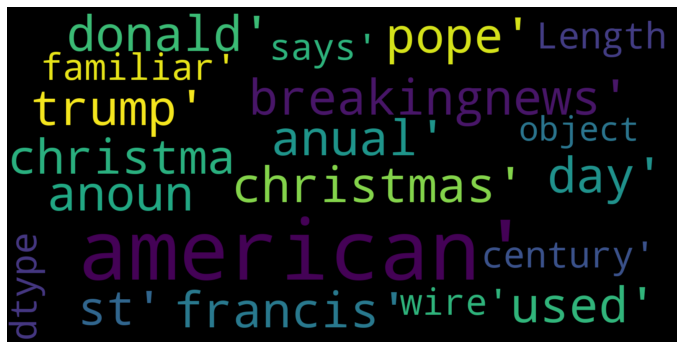

In [ ]:
data1=data[data['label']=='true']
neg =data1['text']
neg_string = []
for t in neg:
    neg_string.append(t)
neg_string = pandas.Series(neg_string).map(str)
neg_string=str(neg_string)


wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

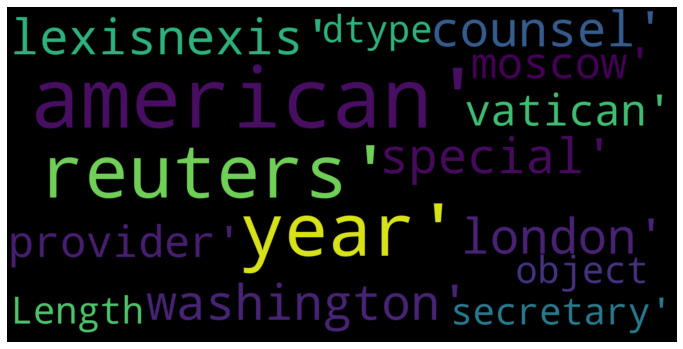

In [ ]:
data1=data[data['label']=='fake']
neg =data1['text']
neg_string = []
for t in neg:
    neg_string.append(t)
neg_string = pandas.Series(neg_string).map(str)
neg_string=str(neg_string)


wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features =1000)

unigramdataGet= word_vectorizer.fit_transform(data['text'].astype('str'))
unigramdataGet = unigramdataGet.toarray()
vocab = word_vectorizer.get_feature_names()
unigramdata=pd.DataFrame(np.round(unigramdataGet, 1), columns=vocab)
unigramdata[unigramdata>0] = 1
unigramdata.head()

,able,absolutely,acept,aces,acording,acount,acr,acros,act,action,...,wrong,wrote,xi,year,yearold,yemen,yes,york,young,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data.reset_index(drop=True, inplace=True)
data=data.drop(columns=['text'])

In [ ]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest


selector = SelectKBest(chi2, k=700)
selector.fit(unigramdata, data['label'])

unigramdata = selector.transform(unigramdata)
print(unigramdata.shape)

(44898, 700)


In [ ]:
X=unigramdata
y=data['label']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=100)

### SVM

In [ ]:
from sklearn.svm import LinearSVC

svc=LinearSVC(C=1, max_iter=500)
svc= svc.fit(X_train , y_train)
svc

LinearSVC(C=1, max_iter=500)

In [ ]:
y_pred1 = svc.predict(X_test)
y_pred_SVM= svc.predict(X_test)
dm=svc.score(X_test, y_test)
print('Accuracy score= {:.2f}'.format(svc.score(X_test, y_test)))

Accuracy score= 0.80


In [ ]:
type(y_pred_rf)

numpy.ndarray

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


print('\n')
print("Precision, Recall, F1")
print('\n')
CR=classification_report(y_test, y_pred1)
print(CR)
print('\n')



Precision, Recall, F1


              precision    recall  f1-score   support

        fake       0.85      0.71      0.77      6414
        true       0.77      0.88      0.82      7056

    accuracy                           0.80     13470
   macro avg       0.81      0.79      0.80     13470
weighted avg       0.81      0.80      0.80     13470







confusion matrix


[[4525 1889]
 [ 818 6238]]




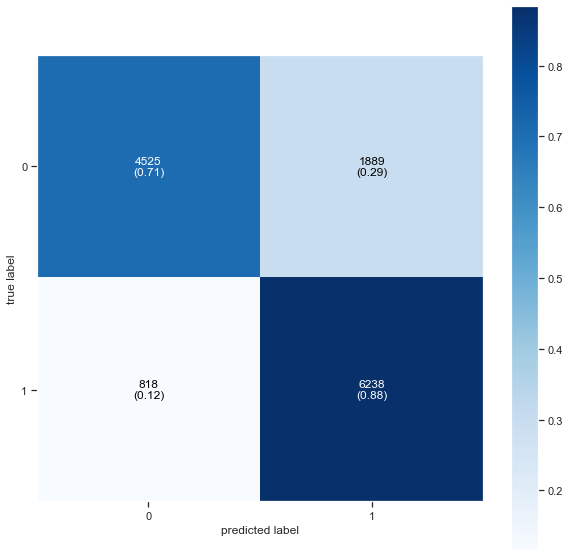

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(y_test, y_pred1)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC


nab=GaussianNB(var_smoothing=1e-08)
nab= nab.fit(X_train , y_train)
nab

GaussianNB(var_smoothing=1e-08)

In [ ]:
y_pred_naive = nab.predict(X_test)
nb=nab.score(X_test, y_test)
print('Accuracy score= {:.2f}'.format(nab.score(X_test, y_test)))

Accuracy score= 0.73


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


print('\n')
print("Precision, Recall, F1")
print('\n')
CR=classification_report(y_test, y_pred1)
print(CR)
print('\n')



Precision, Recall, F1


              precision    recall  f1-score   support

        fake       0.85      0.53      0.65      6414
        true       0.68      0.92      0.78      7056

    accuracy                           0.73     13470
   macro avg       0.77      0.72      0.72     13470
weighted avg       0.76      0.73      0.72     13470







confusion matrix


[[3376 3038]
 [ 578 6478]]




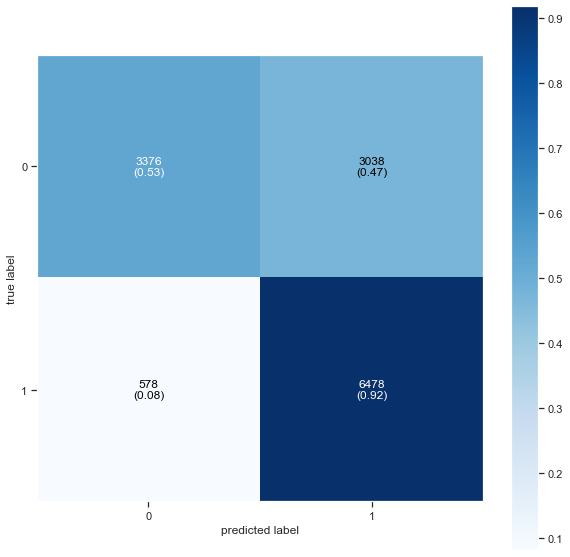

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(y_test, y_pred1)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC


lor=LogisticRegression(C=2, max_iter=100)
lor= lor.fit(X_train , y_train)
lor

LogisticRegression(C=2)

In [ ]:
y_pred1 = lor.predict(X_test)
y_pred_lr=lor.predict(X_test)
lr=lor.score(X_test, y_test)
print('Accuracy score= {:.2f}'.format(lor.score(X_test, y_test)))

Accuracy score= 0.80


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


print('\n')
print("Precision, Recall, F1")
print('\n')
CR=classification_report(y_test, y_pred1)
print(CR)
print('\n')



Precision, Recall, F1


              precision    recall  f1-score   support

        fake       0.85      0.71      0.77      6414
        true       0.77      0.88      0.82      7056

    accuracy                           0.80     13470
   macro avg       0.81      0.80      0.80     13470
weighted avg       0.81      0.80      0.80     13470







confusion matrix


[[4533 1881]
 [ 816 6240]]




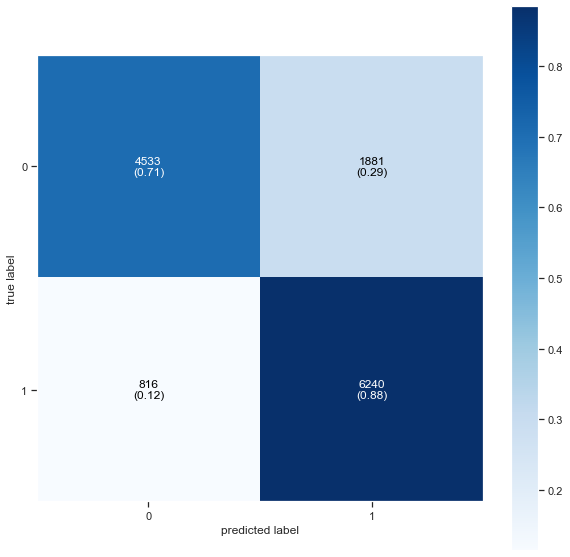

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(y_test, y_pred1)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

### Random Forest 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

raf=RandomForestClassifier(min_samples_leaf=20, min_samples_split=20,random_state=100)
raf= raf.fit(X_train , y_train)
raf

RandomForestClassifier(min_samples_leaf=20, min_samples_split=20,
                       random_state=100)

In [ ]:
y_pred1 = raf.predict(X_test)
y_pred_rf = raf.predict(X_test)
rf=raf.score(X_test, y_test)
print('Accuracy score= {:.2f}'.format(raf.score(X_test, y_test)))

Accuracy score= 0.79


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


print('\n')
print("Precision, Recall, F1")
print('\n')
CR=classification_report(y_test, y_pred1)
print(CR)
print('\n')



Precision, Recall, F1


              precision    recall  f1-score   support

        fake       0.84      0.69      0.76      6414
        true       0.76      0.88      0.82      7056

    accuracy                           0.79     13470
   macro avg       0.80      0.79      0.79     13470
weighted avg       0.80      0.79      0.79     13470







confusion matrix


[[4440 1974]
 [ 828 6228]]




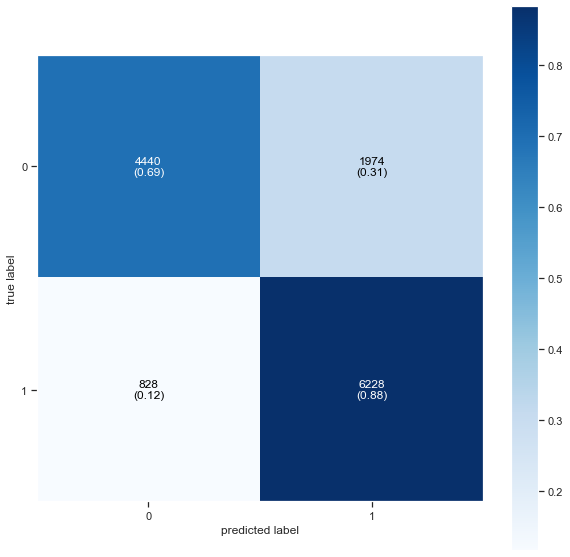

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(y_test, y_pred1)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [ ]:
# Ensemble Technique to combine all algorithms and making one
svc = LinearSVC(C=1, max_iter=500)
nab  = GaussianNB(var_smoothing=1e-08)
log  = LogisticRegression(C=2, max_iter=100)
raf  = RandomForestClassifier(min_samples_leaf=10, min_samples_split=20,random_state=100)

In [ ]:
from sklearn.ensemble import VotingClassifier
Ens = VotingClassifier( estimators= [('SVM',svc),('NB',nab),('Log',log),('raf',raf)], voting = 'hard')
Ens= Ens.fit(X_train , y_train)
Ens

VotingClassifier(estimators=[('SVM', LinearSVC(C=1, max_iter=500)),
                             ('NB', GaussianNB(var_smoothing=1e-08)),
                             ('Log', LogisticRegression(C=2)),
                             ('raf',
                              RandomForestClassifier(min_samples_leaf=20,
                                                     min_samples_split=20,
                                                     random_state=100))])

In [ ]:
y_pred1 = Ens.predict(X_test)
y_pred_vc=Ens.predict(X_test)
en=Ens.score(X_test, y_test)
print('Accuracy score= {:.2f}'.format(Ens.score(X_test, y_test)))

Accuracy score= 0.80


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


print('\n')
print("Precision, Recall, F1")
print('\n')
CR=classification_report(y_test, y_pred1)
print(CR)
print('\n')



Precision, Recall, F1


              precision    recall  f1-score   support

        fake       0.84      0.71      0.77      6414
        true       0.77      0.87      0.82      7056

    accuracy                           0.80     13470
   macro avg       0.80      0.79      0.79     13470
weighted avg       0.80      0.80      0.80     13470







confusion matrix


[[4582 1832]
 [ 900 6156]]




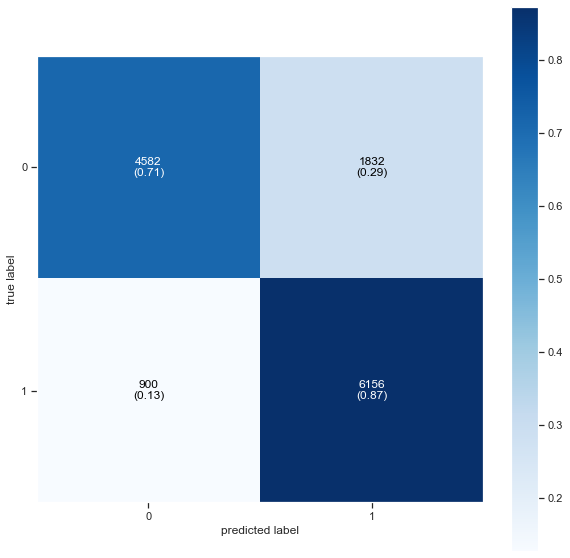

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(y_test, y_pred1)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Gradient boosting
Training accuracy:   0.815
Testing accuracy:   0.800
[[4525 1889]
 [ 803 6253]]
              precision    recall  f1-score   support

        fake       0.85      0.71      0.77      6414
        true       0.77      0.89      0.82      7056

    accuracy                           0.80     13470
   macro avg       0.81      0.80      0.80     13470
weighted avg       0.81      0.80      0.80     13470

Classification accuracy : 0.8001
Classification error : 0.1999


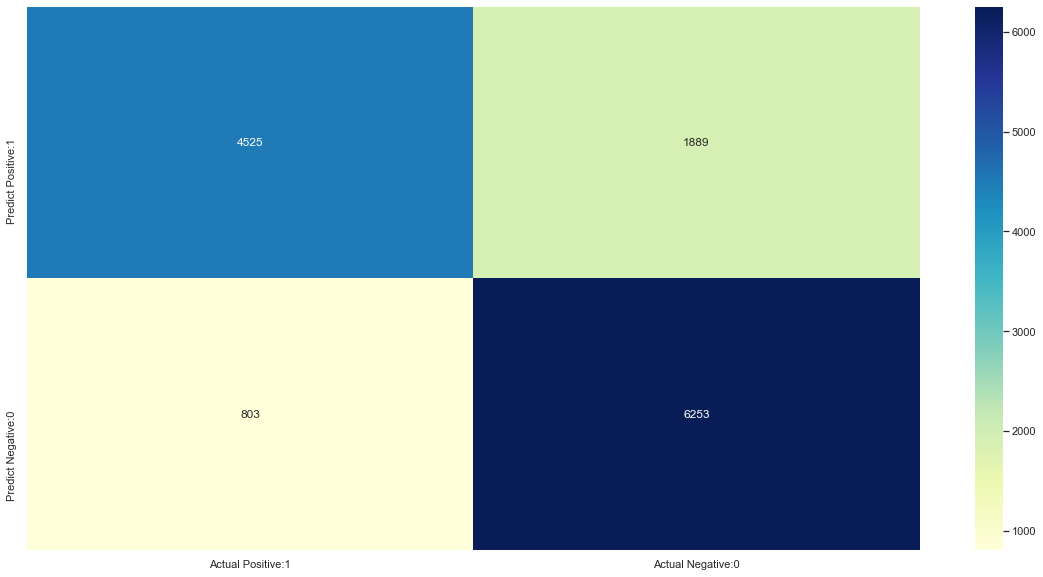

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(learning_rate = 0.05, subsample = 0.7, max_depth = 9, n_estimators = 100)
clf.fit(X_train, y_train)
y_predict_GB=clf.predict(X_test)
print("Gradient boosting")
print("Training accuracy:   %0.3f" % clf.score(X_train,y_train))
print("Testing accuracy:   %0.3f" % clf.score(X_test,y_test))
cm_GB_euc = confusion_matrix(y_test, y_predict_GB)
print(cm_GB_euc)

cm_matrix = pd.DataFrame(data=cm_GB_euc, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
print(classification_report(y_test, y_predict_GB))

TP = cm_GB_euc[0,0]
TN = cm_GB_euc[1,1]
FP = cm_GB_euc[0,1]
FN = cm_GB_euc[1,0]

classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)

print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

# print classification error

classification_error = (FP + FN) / float(TP + TN + FP + FN)

print('Classification error : {0:0.4f}'.format(classification_error))

In [ ]:
y_pred_SVM[y_pred_SVM=='fake']=0
y_pred_SVM[y_pred_SVM=='true']=1
y_pred_naive[y_pred_naive=='fake']=0
y_pred_naive[y_pred_naive=='true']=1
y_pred_lr[y_pred_lr=='fake']=0
y_pred_lr[y_pred_lr=='true']=1
y_pred_rf[y_pred_rf=='fake']=0
y_pred_rf[y_pred_rf=='true']=1
y_pred_vc[y_pred_vc=='fake']=0
y_pred_vc[y_pred_vc=='true']=1
y_predict_GB[y_predict_GB=='fake']=0
y_predict_GB[y_predict_GB=='true']=1

In [ ]:
y_test[y_test=='true']=1
y_test[y_test=='fake']=0

In [ ]:
mean_squared_error(y_test, y_pred_SVM)

0.20096510764662212

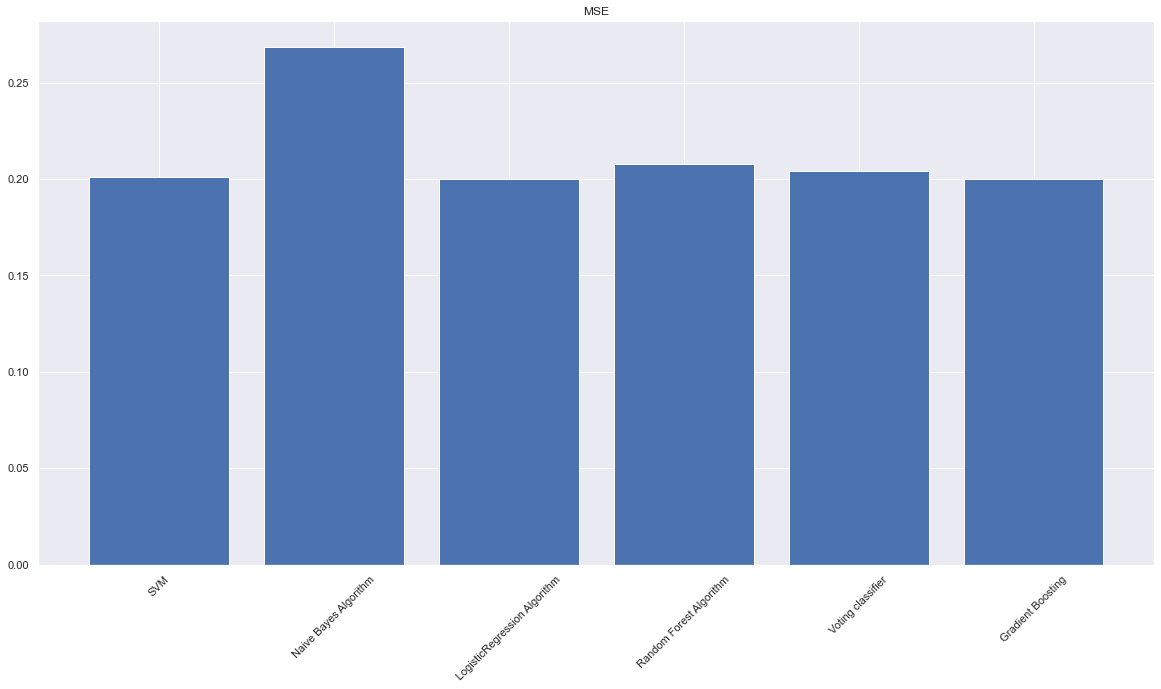

In [ ]:
#MSE score
from sklearn.metrics import mean_squared_error
x=['SVM','Naive Bayes Algorithm','LogisticRegression Algorithm','Random Forest Algorithm','Voting classifier','Gradient Boosting']
MSE_score_array=[]
# MSE_score_array.append('0.1')
MSE_score_array.append(mean_squared_error(y_test, y_pred_SVM))
MSE_score_array.append(mean_squared_error(y_test, y_pred_naive))
MSE_score_array.append(mean_squared_error(y_test, y_pred_lr))
MSE_score_array.append(mean_squared_error(y_test, y_pred_rf))
MSE_score_array.append(mean_squared_error(y_test, y_pred_vc))
MSE_score_array.append(mean_squared_error(y_test, y_predict_GB))
import matplotlib.pyplot as plt
import numpy as np
plt.bar(x,MSE_score_array)
plt.xticks(rotation = 45)
# plt.yticks(np.arange(min(y), max(y)+1, 3))
plt.title('MSE')
plt.show()

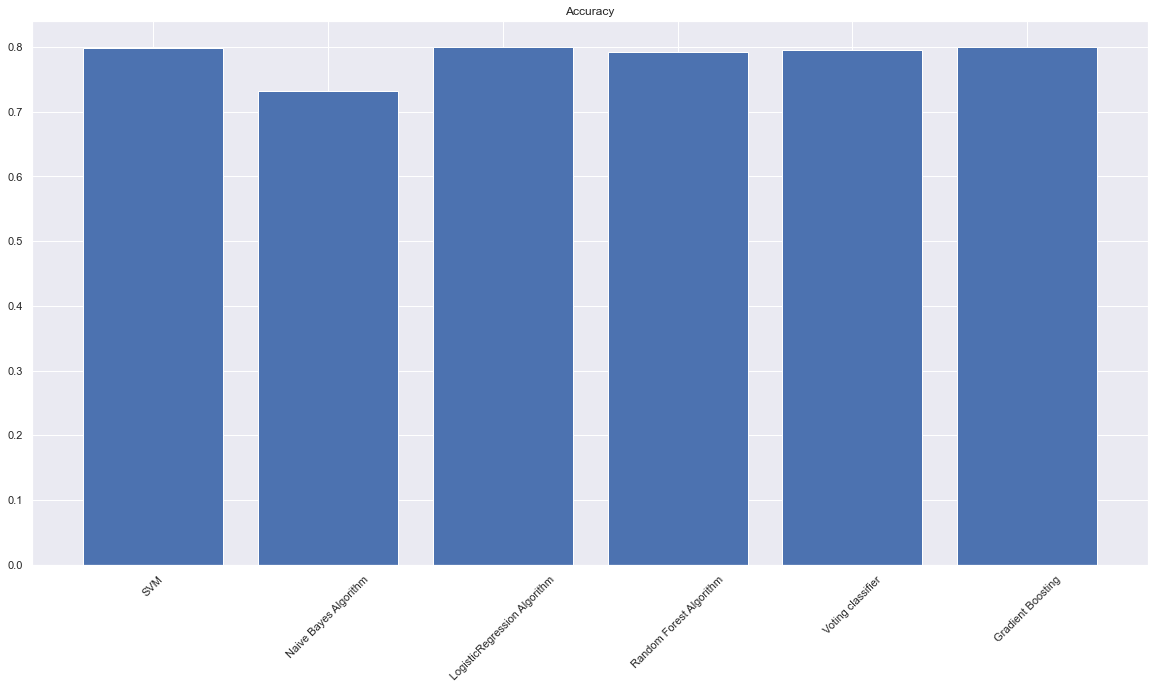

In [ ]:
x=['SVM','Naive Bayes Algorithm','LogisticRegression Algorithm','Random Forest Algorithm','Voting classifier','Gradient Boosting']
acc_score_array=[]
acc_score_array.append(dm)
acc_score_array.append(nb)
acc_score_array.append(lr)
acc_score_array.append(rf)
acc_score_array.append(en)
acc_score_array.append(classification_accuracy)

plt.bar(x,acc_score_array)
plt.xticks(rotation = 45)
# plt.yticks(np.arange(min(y), max(y)+1, 3))
plt.title('Accuracy')
plt.show()

In [ ]:
from IPython.display import display
import pandas as pd

names=['SVM','Naive Bayes Algorithm','LogisticRegression Algorithm','Random Forest Algorithm','Voting classifier','Gradient Boosting']
# creating a DataFrame
dict = {'Classifier' : names,
        'Accuracy' : acc_score_array,
        'MSE' : MSE_score_array}
df = pd.DataFrame(dict)
  
# displaying the DataFrame
display(df)

,Classifier,Accuracy,MSE
0,SVM,0.799035,0.200965
1,Naive Bayes Algorithm,0.731552,0.268448
2,LogisticRegression Algorithm,0.799777,0.200223
3,Random Forest Algorithm,0.791982,0.208018
4,Voting classifier,0.795768,0.204232
5,Gradient Boosting,0.800148,0.199852


In [ ]:
from prettytable import PrettyTable
x = PrettyTable()
print('\n')
print("Comparison of all algorithm results")
x.field_names = ["Model", "Accuracy"]


x.add_row(["SVM Algorithm", round(dm,2)])
x.add_row(["Naive Bayes Algorithm", round(nb,2)])
x.add_row(["LogisticRegression Algorithm", round(lr,2)])
x.add_row(["Random Forest Algorithm", round(rf,2)])
x.add_row(["Ensemble Modelling", round(en,2)])

print(x)
print('\n')



Comparison of all algorithm results
+------------------------------+----------+
|            Model             | Accuracy |
+------------------------------+----------+
|        SVM Algorithm         |   0.8    |
|    Naive Bayes Algorithm     |   0.73   |
| LogisticRegression Algorithm |   0.8    |
|   Random Forest Algorithm    |   0.79   |
|      Ensemble Modelling      |   0.8    |
+------------------------------+----------+




# RNN(LSTM Network)

In [9]:
#Changing our present working directory

os.chdir('/content/drive/My Drive/AML project')

#Importing the dataset with fake and real news again

fake = pd.read_csv('/content/drive/My Drive/AML project/Fake.csv')
real = pd.read_csv('/content/drive/My Drive/AML project/True.csv')

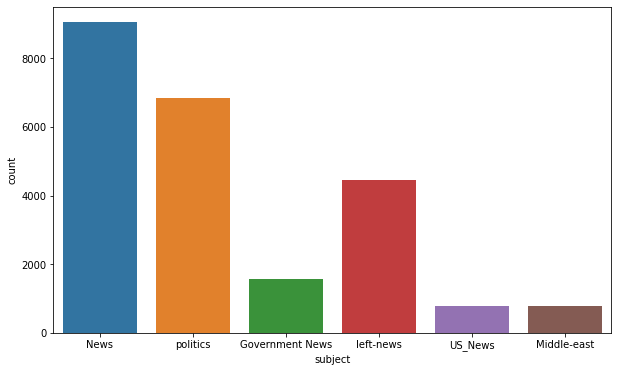

In [10]:
#Using seaborn to plot the data

plt.figure(figsize=(10,6))
sns.countplot(x='subject',data=fake)

In [11]:
#Now we try to find the publishers of the news text/articles

unknown_publishers = []

for idx,values in enumerate(real.text.values):
  try:
    record = row.split('-',maxsplit=1)
    record[1]

    assert(len(record[0])<120)

  except:
    unknown_publishers.append(idx)

real.iloc[unknown_publishers].text

0        WASHINGTON (Reuters) - The head of a conservat...
1        WASHINGTON (Reuters) - Transgender people will...
2        WASHINGTON (Reuters) - The special counsel inv...
3        WASHINGTON (Reuters) - Trump campaign adviser ...
4        SEATTLE/WASHINGTON (Reuters) - President Donal...
                               ...                        
21412    BRUSSELS (Reuters) - NATO allies on Tuesday we...
21413    LONDON (Reuters) - LexisNexis, a provider of l...
21414    MINSK (Reuters) - In the shadow of disused Sov...
21415    MOSCOW (Reuters) - Vatican Secretary of State ...
21416    JAKARTA (Reuters) - Indonesia will buy 11 Sukh...
Name: text, Length: 21417, dtype: object

In [12]:
#We observe that there consists row no 8970 which contains no news content

real.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [13]:
#So we drop that row with the blank text

real.drop(8970,axis=0)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [14]:
#Splitting our text between publisher and news text

publisher = []
temp_text = []

for idx,value in enumerate(real.text.values):
  if idx in unknown_publishers:
    temp_text.append(value)
    publisher.append('Unknown')
  else:
    record = value.split('-',maxsplit=1)
    publisher.append(record[0].strip())
    temp_text.append(record[1].strip())

In [15]:
#The split text will now become two new columns of the dataset

real['publisher'] = publisher
real['text'] = temp_text

In [16]:
empty_fake_idx = [idx for idx,value in enumerate(fake.text.tolist()) if str(value).strip() == '']

fake.iloc[empty_fake_idx]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [17]:
real['text'] = real['title'] + ' ' + real['text']
fake['text'] = fake['title'] + ' ' + fake['text']

real['text'] = real['text'].apply(lambda x: str(x).lower())
fake['text'] = fake['text'].apply(lambda x: str(x).lower())

real['class'] = 1.0
fake['class'] = 0.0

In [19]:
#Performing feature selection

real_df = real.iloc[:,[1,5]]
fake_df = fake.iloc[:,[1,4]]

real_df.head()

,text,class
0,"as u.s. budget fight looms, republicans flip t...",1.0
1,u.s. military to accept transgender recruits o...,1.0
2,senior u.s. republican senator: 'let mr. muell...,1.0
3,fbi russia probe helped by australian diplomat...,1.0
4,trump wants postal service to charge 'much mor...,1.0


In [20]:
dataset = real_df.append(fake_df,ignore_index=True)

#This is how our combined data looks like

dataset.head()

,text,class
0,"as u.s. budget fight looms, republicans flip t...",1.0
1,u.s. military to accept transgender recruits o...,1.0
2,senior u.s. republican senator: 'let mr. muell...,1.0
3,fbi russia probe helped by australian diplomat...,1.0
4,trump wants postal service to charge 'much mor...,1.0


In [25]:
dataset['text'] = dataset['text'].apply(lambda x: ps.remove_special_chars(x))

In [26]:
#Splitting our data

y = dataset['class'].values

X = [d.split() for d in dataset['text'].tolist()]

In [27]:
#dims stand for output dimensions here

dims=125
w2vec = gensim.models.Word2Vec(sentences=X,size=dims,window=15,min_count=1)

In [28]:
#Checking out the length of our word2Vector model

len(w2vec.wv.vocab)

232476

In [29]:
#Checking the vocabulary of the vectorized words

w2vec.wv.vocab

{'as': <gensim.models.keyedvectors.Vocab at 0x7f751f0cb190>,
 'us': <gensim.models.keyedvectors.Vocab at 0x7f751f0cbdd0>,
 'budget': <gensim.models.keyedvectors.Vocab at 0x7f751f0cddd0>,
 'fight': <gensim.models.keyedvectors.Vocab at 0x7f75209a7110>,
 'looms': <gensim.models.keyedvectors.Vocab at 0x7f74d8fa1ad0>,
 'republicans': <gensim.models.keyedvectors.Vocab at 0x7f74d8fa1c10>,
 'flip': <gensim.models.keyedvectors.Vocab at 0x7f74d8fa1e50>,
 'their': <gensim.models.keyedvectors.Vocab at 0x7f74d8fa1990>,
 'fiscal': <gensim.models.keyedvectors.Vocab at 0x7f75201f8e50>,
 'script': <gensim.models.keyedvectors.Vocab at 0x7f74d8fa1fd0>,
 'washington': <gensim.models.keyedvectors.Vocab at 0x7f74d8fa1c50>,
 'reuters': <gensim.models.keyedvectors.Vocab at 0x7f74d8fa1e90>,
 'the': <gensim.models.keyedvectors.Vocab at 0x7f74d8fa1ed0>,
 'head': <gensim.models.keyedvectors.Vocab at 0x7f74d8fa1d90>,
 'of': <gensim.models.keyedvectors.Vocab at 0x7f74d8fa1f90>,
 'a': <gensim.models.keyedvectors.Voc

In [30]:
#Defining the tokenizer instance and fitting our input text data on it

tokenizer = Tokenizer()

tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [31]:
#Observing the index that has been assigned to the words of our sequence

tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'a': 4,
 'and': 5,
 'in': 6,
 'that': 7,
 'on': 8,
 'for': 9,
 's': 10,
 'is': 11,
 'he': 12,
 'said': 13,
 'trump': 14,
 'it': 15,
 'with': 16,
 'was': 17,
 'as': 18,
 'his': 19,
 'by': 20,
 'has': 21,
 'be': 22,
 'have': 23,
 'not': 24,
 'from': 25,
 'this': 26,
 'at': 27,
 'are': 28,
 'who': 29,
 'us': 30,
 'an': 31,
 'they': 32,
 'i': 33,
 'but': 34,
 'we': 35,
 'would': 36,
 'president': 37,
 'about': 38,
 'will': 39,
 'their': 40,
 'had': 41,
 'you': 42,
 't': 43,
 'been': 44,
 'were': 45,
 'people': 46,
 'more': 47,
 'or': 48,
 'after': 49,
 'which': 50,
 'she': 51,
 'her': 52,
 'one': 53,
 'if': 54,
 'its': 55,
 'out': 56,
 'all': 57,
 'what': 58,
 'new': 59,
 'state': 60,
 'when': 61,
 'also': 62,
 'up': 63,
 'there': 64,
 'over': 65,
 'no': 66,
 'house': 67,
 'reuters': 68,
 'donald': 69,
 'our': 70,
 'states': 71,
 'clinton': 72,
 'obama': 73,
 'government': 74,
 'can': 75,
 'just': 76,
 'him': 77,
 'so': 78,
 'than': 79,
 'republican': 80,
 '

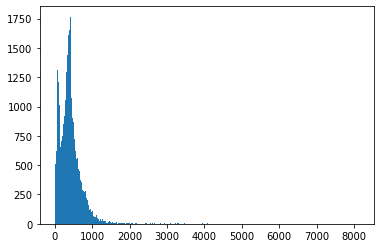

In [32]:
#Plotting a histogram to see the spread of token numbers in our input

plt.hist([len(token) for token in X],bins=500)
plt.show()

In [33]:
#Selecting only those token which are greater than 1000 in lengh from our inpur feature X

nos = np.array([len(token) for token in X])
len(nos[nos>1000])

1592

In [34]:
max_length=1000
X = pad_sequences(X,maxlen=max_length)

vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [35]:
def retrieve_weight_matrix(model,vocab):
  vocab_size = len(tokenizer.word_index) + 1
  
  weight_matrix = np.zeros((vocab_size,dims))

  for word,i in vocab.items():
    weight_matrix[i] = model.wv[word]

  return weight_matrix

In [36]:
embeddings = retrieve_weight_matrix(w2vec,vocab)
embeddings.shape

(232477, 125)

In [38]:
#We finally define the layers of our RNN model here

model = Sequential()
model.add(Embedding(vocab_size,output_dim=dims,weights=[embeddings],input_length=max_length,trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [39]:
#Summarizing our Model's architecture

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 125)         29059625  
                                                                 
 lstm_1 (LSTM)               (None, 128)               130048    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 29,189,802
Trainable params: 130,177
Non-trainable params: 29,059,625
_________________________________________________________________


In [40]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [41]:
model.fit(X_train,y_train, validation_split=0.3, epochs=8)

Epoch 1/8
737/737 [==============================] - 128s 167ms/step - loss: 0.1195 - acc: 0.9571 - val_loss: 0.0251 - val_acc: 0.9924
Epoch 2/8
737/737 [==============================] - 122s 165ms/step - loss: 0.0243 - acc: 0.9927 - val_loss: 0.0286 - val_acc: 0.9907
Epoch 3/8
737/737 [==============================] - 122s 166ms/step - loss: 0.0097 - acc: 0.9978 - val_loss: 0.0111 - val_acc: 0.9969
Epoch 4/8
737/737 [==============================] - 122s 166ms/step - loss: 0.0087 - acc: 0.9976 - val_loss: 0.0120 - val_acc: 0.9960
Epoch 5/8
737/737 [==============================] - 122s 166ms/step - loss: 0.0058 - acc: 0.9984 - val_loss: 0.0081 - val_acc: 0.9980
Epoch 6/8
737/737 [==============================] - 122s 166ms/step - loss: 0.0082 - acc: 0.9978 - val_loss: 0.0091 - val_acc: 0.9972
Epoch 7/8
737/737 [==============================] - 122s 166ms/step - loss: 0.0039 - acc: 0.9989 - val_loss: 0.0117 - val_acc: 0.9965
Epoch 8/8
737/737 [==============================] - 12

In [42]:
y_pred = (model.predict(X_test) >= 0.5).astype(int)

print(accuracy_score(y_test,y_pred))

0.9934966592427616


In [43]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      5819
         1.0       0.99      1.00      0.99      5406

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [45]:
#Now we try and test our model on individual data entries to see how it performs

news_piece = ['This is a shocking news!']
news_piece = tokenizer.texts_to_sequences(news_piece)
news_piece = pad_sequences(news_piece,maxlen=max_length)

(model.predict(news_piece) >= 0.5).astype(int)

array([[0]])

# CatBoost

In [46]:
dataset

,text,class
0,as us budget fight looms republicans flip thei...,1.0
1,us military to accept transgender recruits on ...,1.0
2,senior us republican senator let mr mueller do...,1.0
3,fbi russia probe helped by australian diplomat...,1.0
4,trump wants postal service to charge much more...,1.0
...,...,...
44893,mcpain john mccain furious that iran treated u...,0.0
44894,justice yahoo settles email privacy classactio...,0.0
44895,sunnistan us and allied safe zone plan to take...,0.0
44896,how to blow 700 million al jazeera america fin...,0.0


In [47]:
yy = dataset['class'].values

#XX = [d.split() for d in dataset['text'].tolist()]
XX = dataset.iloc[:,0]

In [48]:
#from sklearn.cross_validation import train_test_split

#X_train,X_test,y_train,y_test = train_test_split(XX,yy)

msk = np.random.rand(len(dataset)) < 0.8
data_train = dataset[msk]
data_test = dataset[~msk]

In [49]:
X_train = pd.DataFrame(data_train['text'].values,columns=['text'])
X_test = pd.DataFrame(data_test['text'].values,columns=['text'])
y_train = data_train.iloc[:,1]
y_test = data_test.iloc[:,1]

In [50]:
#Creating our data pools to feed into the CatBoost Classifer

train_pool = Pool(
    data=X_train,
    label=y_train,
    text_features=['text']
)
test_pool = Pool(
    data=X_test, 
    label=y_test,
    text_features=['text']
)

In [51]:
#Finally defining our model acrhitecture

model = CatBoostClassifier(task_type='GPU',iterations=3000,eval_metric='Accuracy',tokenizers=[
        {
            'tokenizer_id': 'Sense',
            'separator_type': 'BySense',
            'lowercasing': 'True',
            'token_types':['Word', 'Number', 'SentenceBreak'],
            'sub_tokens_policy':'SeveralTokens'
        }      
    ],
    dictionaries = [
        {
            'dictionary_id': 'Word',
            'max_dictionary_size': '50000'
        }
    ],
    feature_calcers = [
        'BoW:top_tokens_count=10000'
    ])
history = model.fit(train_pool,eval_set=test_pool,plot=True,use_best_model=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.033334
0:	learn: 0.9935241	test: 0.9914031	best: 0.9914031 (0)	total: 224ms	remaining: 11m 11s
1:	learn: 0.9935799	test: 0.9918439	best: 0.9918439 (1)	total: 437ms	remaining: 10m 54s
2:	learn: 0.9931612	test: 0.9912928	best: 0.9918439 (1)	total: 602ms	remaining: 10m 1s
3:	learn: 0.9930775	test: 0.9912928	best: 0.9918439 (1)	total: 759ms	remaining: 9m 28s
4:	learn: 0.9930495	test: 0.9912928	best: 0.9918439 (1)	total: 1.01s	remaining: 10m 8s
5:	learn: 0.9931891	test: 0.9912928	best: 0.9918439 (1)	total: 1.33s	remaining: 11m 3s
6:	learn: 0.9933008	test: 0.9914031	best: 0.9918439 (1)	total: 1.6s	remaining: 11m 25s
7:	learn: 0.9933566	test: 0.9916235	best: 0.9918439 (1)	total: 1.89s	remaining: 11m 45s
8:	learn: 0.9933008	test: 0.9916235	best: 0.9918439 (1)	total: 2.14s	remaining: 11m 50s
9:	learn: 0.9932170	test: 0.9915133	best: 0.9918439 (1)	total: 2.43s	remaining: 12m 5s
10:	learn: 0.9933566	test: 0.9916235	best: 0.9918439 (1)	total: 2.69s	remaining: 12m 10s
11:	lea

In [52]:
#Printing the accuracy of our model

acc = model.score(test_pool)
print('The accuracy of the catboost classifier on our given data is: {}'.format(acc))

The accuracy of the catboost classifier on our given data is: 0.9976854403174253


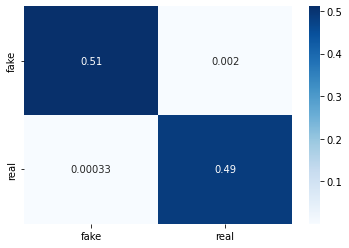

In [53]:
#Generating a confusion matrix

cf_matrix = get_confusion_matrix(model, test_pool)
sns.heatmap(
    cf_matrix/np.sum(cf_matrix),
    annot=True, cmap='Blues',
    xticklabels=['fake','real'],
    yticklabels=['fake','real'])